In [31]:
import math
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import time


class Vector2d():
    """
    2-dimensional vector, support addition and subtraction, support constant multiplication (right multiplication)
    """

    def __init__(self, x, y):
        self.deltaX = x
        self.deltaY = y
        self.length = -1
        self.direction = [0, 0]
        self.vector2d_share()

    def vector2d_share(self):
        if type(self.deltaX) == type(list()) and type(self.deltaY) == type(list()):
            deltaX, deltaY = self.deltaX, self.deltaY
            self.deltaX = deltaY[0] - deltaX[0]
            self.deltaY = deltaY[1] - deltaX[1]
            self.length = math.sqrt(self.deltaX ** 2 + self.deltaY ** 2) * 1.0
            if self.length > 0:
                self.direction = [self.deltaX / self.length, self.deltaY / self.length]
            else:
                self.direction = None
        else:
            self.length = math.sqrt(self.deltaX ** 2 + self.deltaY ** 2) * 1.0
            if self.length > 0:
                self.direction = [self.deltaX / self.length, self.deltaY / self.length]
            else:
                self.direction = None

    def __add__(self, other):
        """
        + Heavy load
        :param other:
        :return:
        """
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX += other.deltaX
        vec.deltaY += other.deltaY
        vec.vector2d_share()
        return vec

    def __sub__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX -= other.deltaX
        vec.deltaY -= other.deltaY
        vec.vector2d_share()
        return vec

    def __mul__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX *= other
        vec.deltaY *= other
        vec.vector2d_share()
        return vec

    def __truediv__(self, other):
        return self.__mul__(1.0 / other)

    def __repr__(self):
        return 'Vector deltaX:{}, deltaY:{}, length:{}, direction:{}'.format(self.deltaX, self.deltaY, self.length,
                                                                             self.direction)


class APF():
    """
    Artificial potential field pathfinding
    """

    def __init__(self, start: (), goal: (), obstacles: [], k_att: float, k_rep: float, rr: float,
                 step_size: float, max_iters: int, goal_threshold: float, is_plot=False):
        """
        :param start: Starting point
        :param goal: End point
        :param obstacles: List of obstacles,each of which is a Vector2d object
        :param k_att: Coefficient of gravity
        :param k_rep: Repulsion coefficient
        :param rr: Repulsion range
        :param step_size: Step length
        :param max_iters: Maximum number of iterations
        :param goal_threshold: Less than this value from the target point is considered to have reached the target point
        :param is_plot: Whether to draw
        """
        self.start = Vector2d(start[0], start[1])
        self.current_pos = Vector2d(start[0], start[1])
        self.goal = Vector2d(goal[0], goal[1])
        self.obstacles = [Vector2d(OB[0], OB[1]) for OB in obstacles]
        self.k_att = k_att
        self.k_rep = k_rep
        self.rr = rr  # Repulsion range
        self.step_size = step_size
        self.max_iters = max_iters
        self.iters = 0
        self.goal_threashold = goal_threshold
        self.path = list()
        self.is_path_plan_success = False
        self.is_plot = is_plot
        self.delta_t = 0.01

    def attractive(self):
        """
        Gravity calculation
        :return: Gravity
        """
        att = (self.goal - self.current_pos) * self.k_att  # The direction is directed by the robot to the target point
        return att
    
    def repulsion(self):
        """
       Repulsion calculation, improve repulsion function, solve unreachable problems
        : return: repulsion size
        """
        rep = Vector2d(0, 0)  # Total repulsion of all obstacles
        for obstacle in self.obstacles:
            # obstacle = Vector2d(0, 0)
            obs_to_rob = self.current_pos - obstacle
            rob_to_goal = self.goal - self.current_pos
            if (obs_to_rob.length > self.rr):  # Beyond obstacle repulsion.
                pass
            else:
                rep_1 = Vector2d(obs_to_rob.direction[0], obs_to_rob.direction[1]) * self.k_rep * (
                        1.0 / obs_to_rob.length - 1.0 / self.rr) / (obs_to_rob.length ** 2) * (rob_to_goal.length ** 2)
                rep_2 = Vector2d(rob_to_goal.direction[0], rob_to_goal.direction[1]) * self.k_rep * ((1.0 / obs_to_rob.length - 1.0 / self.rr) ** 2) * rob_to_goal.length
                rep +=(rep_1+rep_2)
        return rep

    def path_plan(self):
        """
        path plan
        :return:
        """
        while (self.iters < self.max_iters and (self.current_pos - self.goal).length > self.goal_threashold):
            f_vec = self.attractive() + self.repulsion()
            self.current_pos += Vector2d(f_vec.direction[0], f_vec.direction[1]) * self.step_size
            self.iters += 1
            self.path.append([self.current_pos.deltaX, self.current_pos.deltaY])
            if self.is_plot:
                subplot.plot(self.current_pos.deltaX, self.current_pos.deltaY, '.b')
                #subplot.pause(self.delta_t)
        if (self.current_pos - self.goal).length <= self.goal_threashold:
            self.is_path_plan_success = True


obstacles: [[1, 4], [2, 4], [3, 3], [6, 1], [6, 7], [10, 6], [11, 12], [14, 14]]
planed path points:[[1.6017738730725766, 1.4997498822892037], [3.514732868322993, 1.1236708201879768], [4.857632436244808, 2.492195309426028], [6.053710738116221, 4.094394481503339], [7.5274357794789015, 5.4351029206271875], [8.457901456114937, 7.153361548999352], [9.524769983659958, 8.832424725794654], [10.915648306391216, 10.26404598405381], [12.654695441451798, 11.213807788410175], [13.850440419649908, 12.812518902576622], [15.177410358763442, 14.115713957462301], [15.051593210392683, 14.898884301240962]]
path plan success


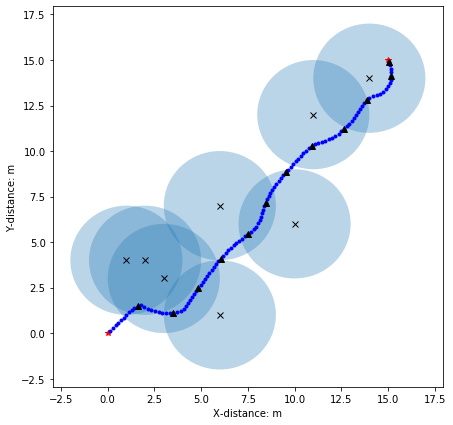

In [32]:
def check_vec_angle(v1: Vector2d, v2: Vector2d):
    v1_v2 = v1.deltaX * v2.deltaX + v1.deltaY * v2.deltaY
    angle = math.acos(v1_v2 / (v1.length * v2.length)) * 180 / math.pi
    return angle


class APF_Improved(APF):
    def __init__(self, start: (), goal: (), obstacles: [], k_att: float, k_rep: float, rr: float,
                 step_size: float, max_iters: int, goal_threshold: float, is_plot=False):
        self.start = Vector2d(start[0], start[1])
        self.current_pos = Vector2d(start[0], start[1])
        self.goal = Vector2d(goal[0], goal[1])
        self.obstacles = [Vector2d(OB[0], OB[1]) for OB in obstacles]
        self.k_att = k_att
        self.k_rep = k_rep
        self.rr = rr  # Repulsion range
        self.step_size = step_size
        self.max_iters = max_iters
        self.iters = 0
        self.goal_threashold = goal_threshold
        self.path = list()
        self.is_path_plan_success = False
        self.is_plot = is_plot
        self.delta_t = 0.01

if __name__ == '__main__':
    # Related parameter settings
    k_att, k_rep = 1.0, 0.8
    rr = 3
    step_size, max_iters, goal_threashold = .2, 500, .2  # Step 0.5 pathfinding 1000 times with 4. 37s, step 0.1 pathfinding 1000 times with 21s    step_size_ = 2

    # Set, draw start and end points
    start, goal = (0, 0), (15, 15)
    is_plot = True
    if is_plot:
        fig = plt.figure(figsize=(7, 7))
        subplot = fig.add_subplot(111)
        subplot.set_xlabel('X-distance: m')
        subplot.set_ylabel('Y-distance: m')
        subplot.plot(start[0], start[1], '*r')
        subplot.plot(goal[0], goal[1], '*r')
    # Obstacle setting and drawing
    obs = [[1, 4], [2, 4], [3, 3], [6, 1], [6, 7], [10, 6], [11, 12], [14, 14]]
    print('obstacles: {0}'.format(obs))
    for i in range(0):
        obs.append([random.uniform(2, goal[1] - 1), random.uniform(2, goal[1] - 1)])

    if is_plot:
        for OB in obs:
            circle = Circle(xy=(OB[0], OB[1]), radius=rr, alpha=0.3)
            subplot.add_patch(circle)
            subplot.plot(OB[0], OB[1], 'xk')
    # t1 = time.time()
    # for i in range(1000):

    # path plan
    if is_plot:
        apf = APF_Improved(start, goal, obs, k_att, k_rep, rr, step_size, max_iters, goal_threashold, is_plot)
    else:
        apf = APF_Improved(start, goal, obs, k_att, k_rep, rr, step_size, max_iters, goal_threashold, is_plot)
    apf.path_plan()
    if apf.is_path_plan_success:
        path = apf.path
        path_ = []
        i = int(step_size_ / step_size)
        while (i < len(path)):
            path_.append(path[i])
            i += int(step_size_ / step_size)

        if path_[-1] != path[-1]:  # Add last point
            path_.append(path[-1])
        print('planed path points:{}'.format(path_))
        print('path plan success')
        if is_plot:
            px, py = [K[0] for K in path_], [K[1] for K in path_]  # Path point x coordinate list, y coordinate list
            subplot.plot(px, py, '^k')
            

    else:
        print('path plan failed')
    # t2 = time.time()
    # print('Wayfinding time of 1000 times:{}, wayfinding time of 1 time:{}'.format(t2-t1, (t2-t1)/1000))